# From optical flow to temperature

### Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.backend as K

### Loading images

In [2]:
data_path = "data/1ball/"

X1 = []
for i in tqdm(glob(data_path + "Input/image1_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X1.append(im)
X1 = np.array(X1, dtype="float32") / 255

X2 = []
for i in tqdm(glob(data_path + "Input/image2_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X2.append(im)
X2 = np.array(X2, dtype="float32") / 255

100%|██████████| 10000/10000 [00:14<00:00, 698.76it/s]


### Generation of synthetic optical flow

For both frames we obtain the pixels where the ball is present and store them in a list. This list will serve us to know the pixel (center of ball) where we need to assign the velocity vector and also to compute the velocity vector, by using the central pixel (mean of pixels) of the ball.

Additionally, we compute the temperature of the system, as the speed of the ball (in this case we only have one ball), that we will try to predict later.

In [3]:
# Dataset dependant parameters
num_systems = 10000
pix = 32

# Initialization of the needed data
optical_flow = np.zeros((num_systems, pix, pix, 2))
temperature = np.zeros((num_systems))

# For each system we compute the optical flow and temperature
for i in tqdm(range(num_systems)):
    # Ball region pixels in first frame
    non_white_x_t0 = []
    non_white_y_t0 = []
    # Ball region pixels in second frame
    non_white_x_t1 = []
    non_white_y_t1 = []
    for j in range(pix):
        for k in range(pix):
            # Check if there's ball in that pixel (first frame)
            if X1[i,j,k] != 1:
                if j not in non_white_y_t0: non_white_y_t0.append(j)
                if k not in non_white_x_t0: non_white_x_t0.append(k)

            # Check if there's ball in that pixel (second frame)
            if X2[i,j,k] != 1:
                if j not in non_white_y_t1: non_white_y_t1.append(j)
                if k not in non_white_x_t1: non_white_x_t1.append(k)
    
    # Compute the vectors and divide by 4 to have (or close to have) them between -1 and 1
    velocity_vector = (np.mean(non_white_x_t1) - np.mean(non_white_x_t0)) / 4, (np.mean(non_white_y_t1) - np.mean(non_white_y_t0)) / 4
    # Compute temperature value
    temperature[i] = np.sqrt(velocity_vector[0]**2 + velocity_vector[1]**2)

    # Assign optical flow to ball center pixel
    optical_flow[i, np.mean(non_white_y_t1).astype(int), np.mean(non_white_x_t1).astype(int)] = velocity_vector

100%|██████████| 10000/10000 [00:41<00:00, 243.35it/s]


Here we print (from left to right) the two frames of the sample, a 3rd image with both balls (black for first frame and purple for second frame) to see the movement, and a 4th image with the synthetic optical flow.

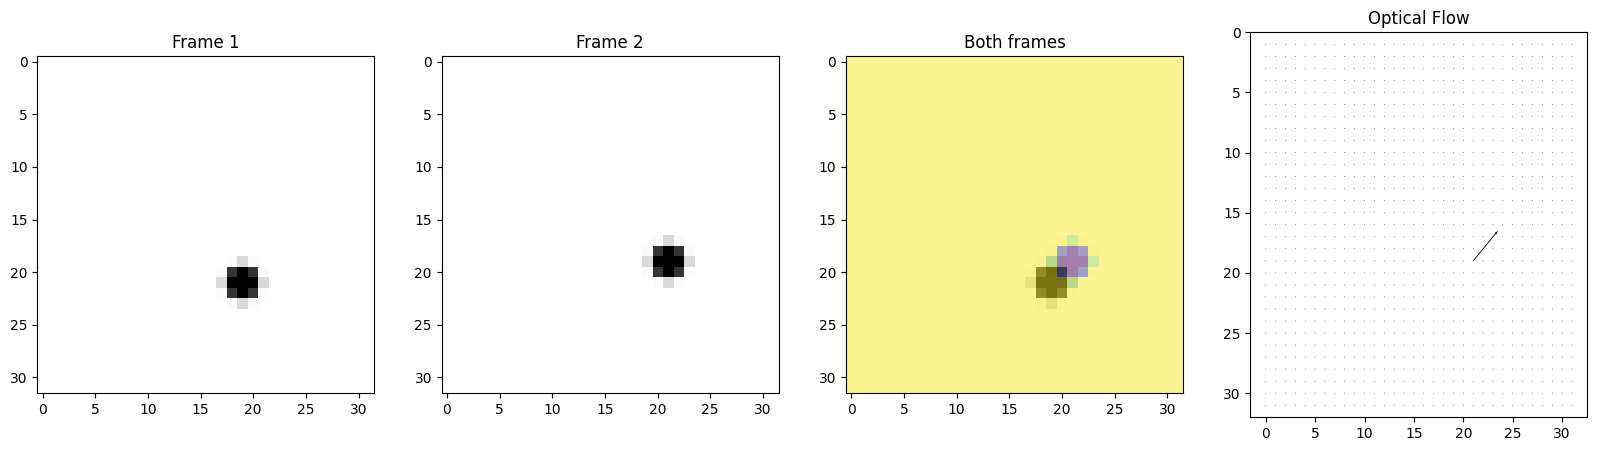

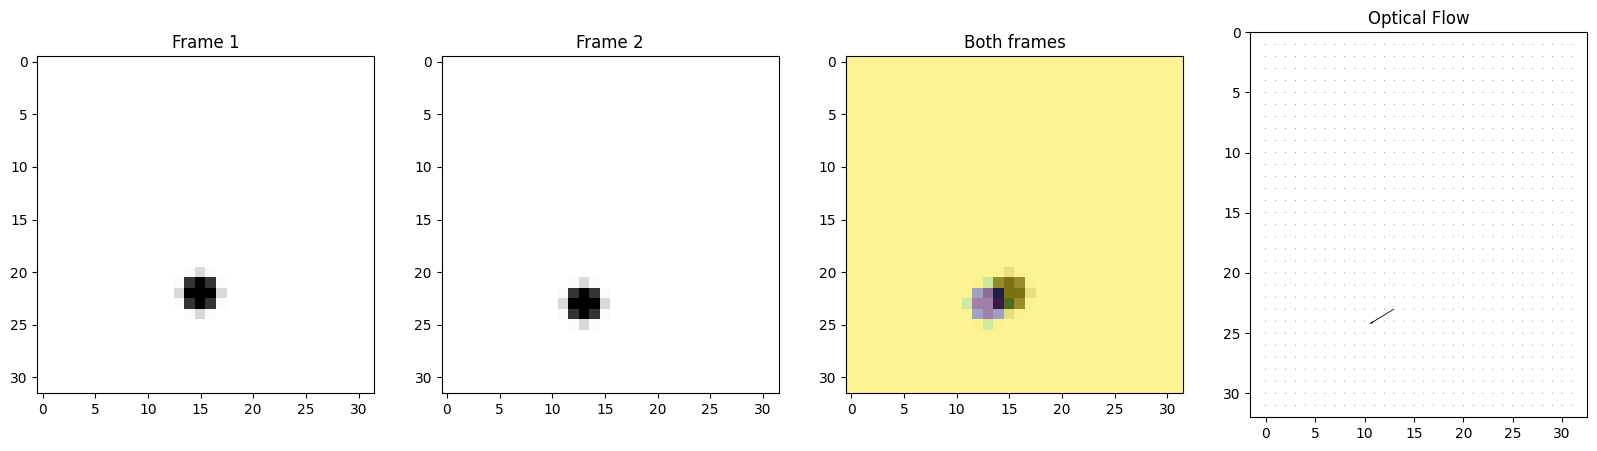

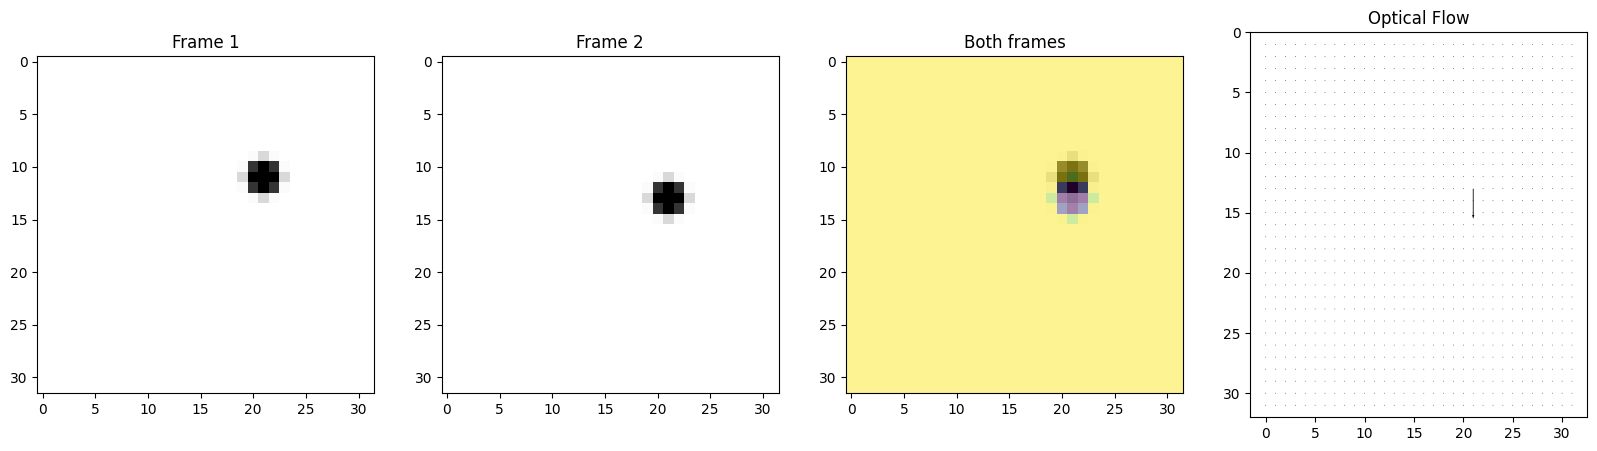

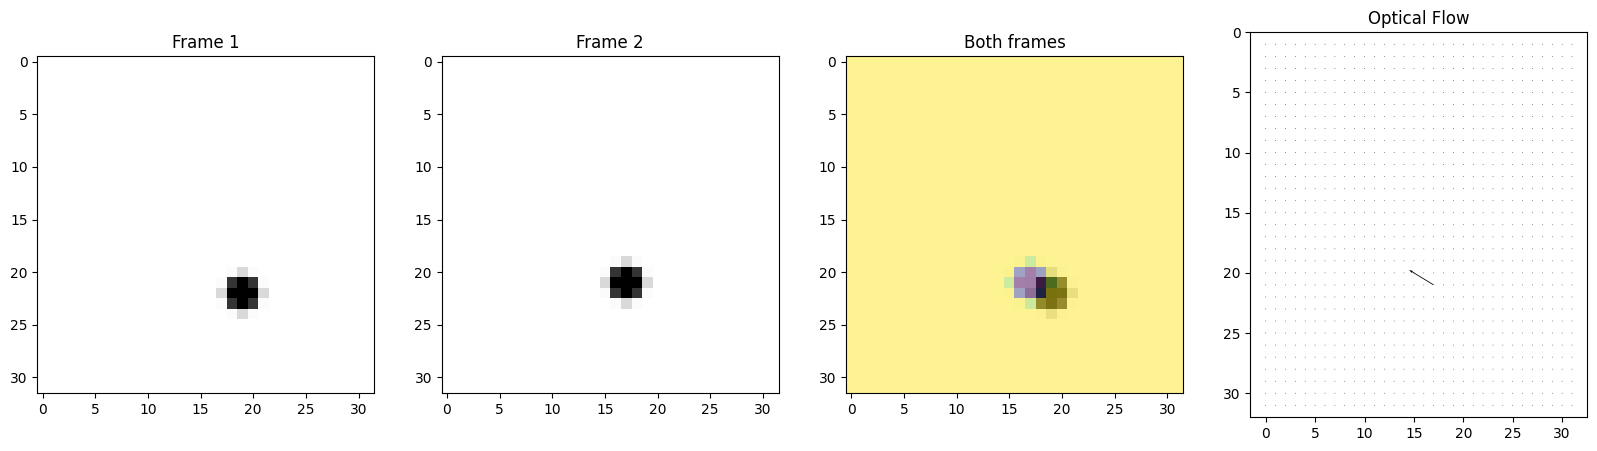

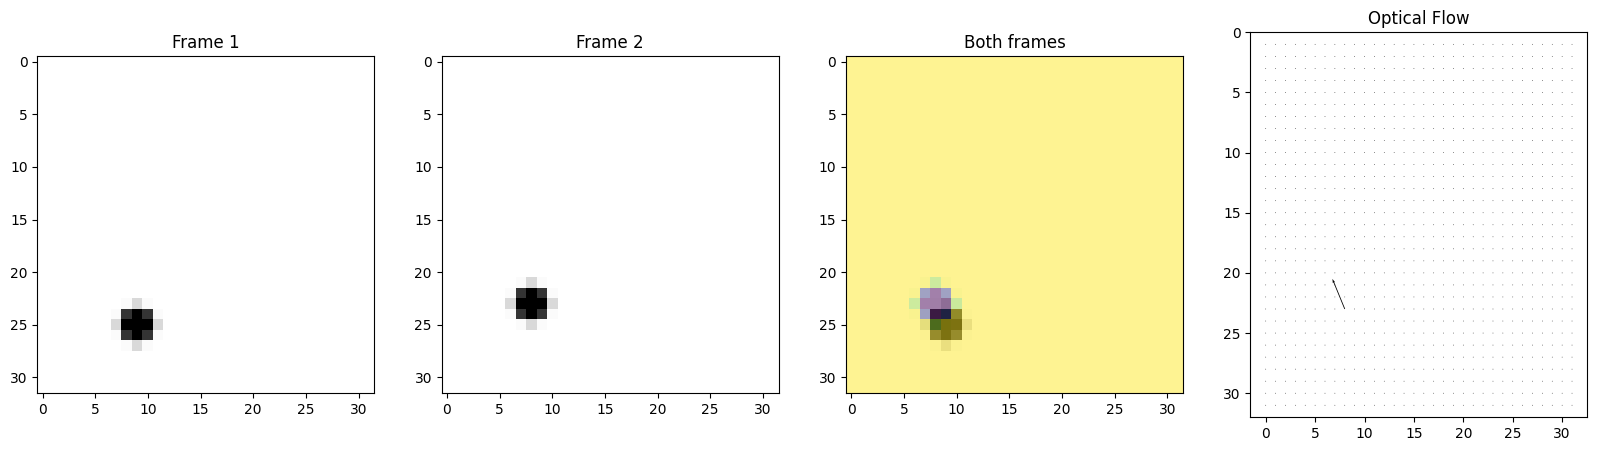

In [4]:
for i in range(5):
    plt.figure(figsize=(20, 5))

    plt.subplot(141)
    plt.title('Frame 1')
    plt.imshow(X1[i], cmap='gray')

    plt.subplot(142)
    plt.title('Frame 2')
    plt.imshow(X2[i], cmap='gray')

    plt.subplot(143)
    plt.title('Both frames')
    plt.imshow(X1[i], cmap='gray')
    plt.imshow(X2[i], alpha=0.5)

    plt.subplot(144)
    plt.ylim(32, 0)
    plt.title('Optical Flow')
    plt.quiver(optical_flow[i, ::1, ::1, 0], optical_flow[i, ::1, ::1, 1],
            angles='xy',            # use 'xy' angles for consistent arrow orientation
            scale_units='xy',       # use 'xy' scale units for consistent arrow length
            scale=0.2)

    plt.show()

plt.close()

### Model definition and training

In [5]:
def model(input_shape):
   inputs = Input(shape=input_shape)

   x = Flatten()(inputs)

   x = Dense(64, activation="relu")(x)
   x = Dense(2)(x)
   outputs = Dense(1)(x)
    
   model = Model(inputs=inputs, outputs=outputs)
   return model

model = model((pix, pix, 2))

model.summary()

# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 131,269
Trainable params: 131,269
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train-val-test split (80-10-10)
x_train, x_test, y_train, y_test = train_test_split(optical_flow, temperature, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')

# Fit the model
model.fit(x_train, y_train,
          epochs=250,
          batch_size=16,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta = 0.0001)])

Epoch 1/250
500/500 [==============================] - 5s 6ms/step - loss: 0.1821 - val_loss: 0.1515
Epoch 2/250
500/500 [==============================] - 2s 5ms/step - loss: 0.1404 - val_loss: 0.1397
Epoch 3/250
500/500 [==============================] - 2s 5ms/step - loss: 0.1160 - val_loss: 0.1227
Epoch 4/250
500/500 [==============================] - 2s 5ms/step - loss: 0.0952 - val_loss: 0.1068
Epoch 5/250
500/500 [==============================] - 2s 5ms/step - loss: 0.0773 - val_loss: 0.0911
Epoch 6/250
500/500 [==============================] - 3s 5ms/step - loss: 0.0643 - val_loss: 0.0770
Epoch 7/250
500/500 [==============================] - 2s 4ms/step - loss: 0.0550 - val_loss: 0.0692
Epoch 8/250
500/500 [==============================] - 2s 4ms/step - loss: 0.0486 - val_loss: 0.0621
Epoch 9/250
500/500 [==============================] - 1s 2ms/step - loss: 0.0442 - val_loss: 0.0591
Epoch 10/250
500/500 [==============================] - 1s 2ms/step - loss: 0.0403 - val_lo

### Model results

In [7]:
predictions = model.predict(x_test)

for i in range(5):
    print(str(i) + '\nPrediction: ' + str(predictions[i]) + '\nActual temperature: ' + str(y_test[i]))

32/32 [==============================] - 0s 2ms/step
0
Prediction: [0.10632324]
Actual temperature: 0.0
1
Prediction: [0.49588403]
Actual temperature: 0.5
2
Prediction: [0.80561924]
Actual temperature: 0.7905694150420949
3
Prediction: [0.2637779]
Actual temperature: 0.25
4
Prediction: [0.3091433]
Actual temperature: 0.3535533905932738


We can see that the results are pretty good, with slight errors in the majority of predictions.